# Imports

In [1]:
import pickle
import torch
import random
import math
import os
import glob
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as T
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image, ImageDraw
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

Dataset Mean/Std

In [2]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch[0]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      nimages += batch.size(0)
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

Data Augmentation

In [3]:
class AddRandomDarkPolygons(object):
    def __init__(self, max_polygons=5, max_vertices=8, max_size=0.5, p=0.5):
        self.max_polygons = max_polygons
        self.max_vertices = max_vertices
        self.max_size = max_size
        self.p = p

    def __call__(self, image):
        if random.random() < self.p:
            image = T.to_pil_image(image)
            draw = ImageDraw.Draw(image)
            width, height = image.size

            num_polygons = random.randint(1, self.max_polygons)
            for _ in range(num_polygons):
                num_vertices = random.randint(3, self.max_vertices)
                polygon_width = int(width * self.max_size)
                polygon_height = int(height * self.max_size)
                start_x = random.randint(0, width - polygon_width)
                start_y = random.randint(0, height - polygon_height)

                polygon = [(start_x + random.randint(0, polygon_width), start_y + random.randint(0, polygon_height)) for _ in range(num_vertices)]
                draw.polygon(polygon, fill=(0, 0, 0))

            image = torch.tensor(np.array(image)).permute(2, 0, 1)

        return image

# from: https://github.com/TheRoboticsClub/gsoc2023-Meiqi_Zhao/tree/main
class ShiftAndAdjustSteer(object):
    def __init__(self, shift_fraction=0.1, steer_adjust=1.0):
        self.shift_fraction = shift_fraction
        self.steer_adjust = steer_adjust

    def __call__(self, image, output):
        # sample a random shift
        max_shift_px = self.shift_fraction * image.shape[2]
        shift_px = torch.tensor([random.uniform(-max_shift_px, max_shift_px), 0])

        # apply the shift to the images
        shifted_img = T.affine(image, angle=0, translate=shift_px.tolist(), scale=1, shear=0, interpolation=T.InterpolationMode.NEAREST)

        # adjust the steering angle according to the shift
        shift_fraction = shift_px[0] / image.shape[2]
        shifted_steer = output[0] + self.steer_adjust * shift_fraction
        shifted_steer = torch.clamp(shifted_steer, -1.0, 1.0)

        image = shifted_img
        output[0] = shifted_steer
        return image, output

class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

Data Preprocessing

In [4]:
class AVDataset(Dataset):
    def __init__(self, data_path, transform):
        self.file_paths = glob.glob(os.path.join(data_path, "*.hdf5"))
        self.file_paths.sort()
        self.lengths = []
        self.total_length = 0
        self.files = []
        for file_path in self.file_paths:
            file = h5py.File(file_path, 'r')
            self.files.append(file)
            length = file['hlc'].shape[0]
            self.lengths.append(length)
            self.total_length += length

        self.transform = transform

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_idx = 0
        while idx >= self.lengths[file_idx]:
            idx -= self.lengths[file_idx]
            file_idx += 1

        file = self.files[file_idx]

        input_image = torch.tensor(file['rgb'][idx]).permute(2, 0, 1)
        speed_value = torch.tensor(file['measurements'][idx][0], dtype=torch.float32)
        speed_value = torch.clamp(speed_value / 40.0, 0, 1.0).to(torch.float32)
        hlc_value = torch.tensor(file['hlc'][idx][0], dtype=torch.long)
        hlc_value = F.one_hot(hlc_value.to(torch.int64), num_classes=4)
        light_value = torch.tensor(file['light'][idx][0], dtype=torch.long)
        light_value = F.one_hot(light_value.to(torch.int64), num_classes=4)
        control_value = file['controls'][idx]

        if self.transform:
            input_image, control_value = ShiftAndAdjustSteer(shift_fraction=0.15, steer_adjust=1.0)(input_image, control_value)
            input_image = v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=None, hue=None)(input_image)
            input_image = v2.RandomApply(torch.nn.ModuleList([v2.GaussianBlur(kernel_size=5, sigma=(0.2, 2.)),]), p=0.5)(input_image)
            #input_image = AddRandomDarkPolygons(p=0.5)(input_image)

        input_image = input_image / 255.0
        input_image = v2.Normalize(mean=(0.7548, 0.7418, 0.7100,), std=(0.1905, 0.1858, 0.1949,))(input_image)
        control_value = torch.tensor([(control_value[0] - control_value[2] + 1.0) / 2.0, (control_value[1]+ 1.0) / 2.0], dtype=torch.float32)

        return input_image, hlc_value, speed_value, light_value, control_value

train_dataset = AVDataset(data_path='/content/drive/My Drive/AV Research/Data/segmentation-carla-driving/train', transform=True)
val_dataset = AVDataset(data_path='/content/drive/My Drive/AV Research/Data/segmentation-carla-driving/val', transform=False)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


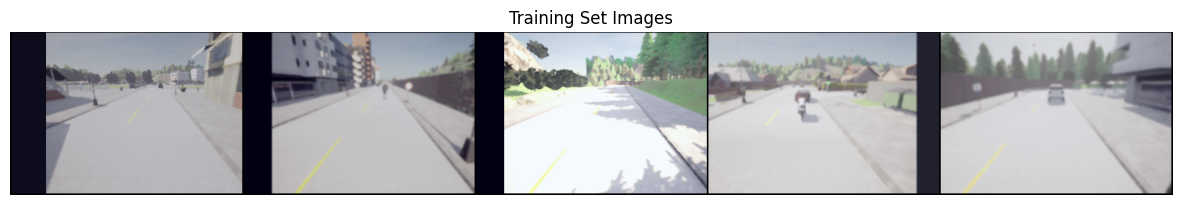

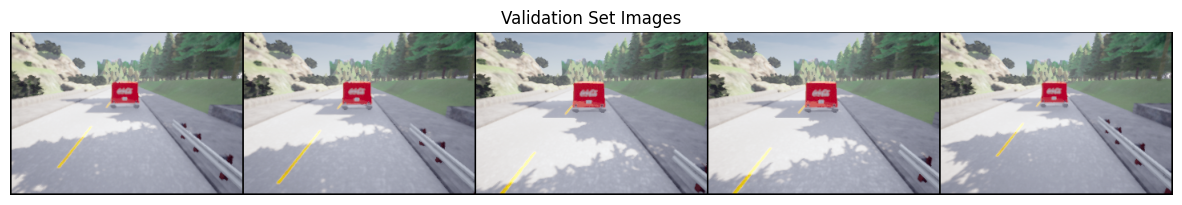

In [5]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    dataiter = iter(loader)
    images, _, _, _, _ = next(dataiter)
    batch_size = images.shape[0]

    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    show_images(random_images, title=title)


plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

In [6]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x

Positional Encoding

In [7]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [8]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

ConvLSTM

In [9]:
#from: https://github.com/ndrplz/ConvLSTM_pytorch
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, num_layers: int):
        super().__init__()
        assert num_layers >= 2, "num_layers must be at least 2"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 2):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        self.out_conv = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)
        out = self.out_conv(out)

        shortcut = self.shortcut(x)
        out = out + shortcut
        out = self.sact(out)

        return out

AV Model

In [11]:
class AVModelLSTM(nn.Module):
    def __init__(self):
        super(AVModelLSTM, self).__init__()
        self.input_layer = nn.Conv2d(3, 8, kernel_size=5, padding=1, stride=4, padding_mode='reflect')

        self.norm = nn.LayerNorm(8)
        self.attention = nn.MultiheadAttention(embed_dim=8, num_heads=1, batch_first=True)
        self.scale = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU()

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=8, out_channels=8, kernel_size=3, stride=2, num_layers=2),
            ResidualBlock(in_channels=8, out_channels=8, kernel_size=3, stride=2, num_layers=2),
            ResidualBlock(in_channels=8, out_channels=16, kernel_size=3, stride=1, num_layers=2),
            ResidualBlock(in_channels=16, out_channels=16, kernel_size=3, stride=1, num_layers=2),
            nn.Dropout2d(0.2),
        )

        self.conv_lstm = ConvLSTM(input_dim=16, hidden_dim=16, kernel_size=(5, 5), num_layers=3, batch_first=True, bias=True, return_all_layers=False)

        self.dense_layers = nn.Sequential(
            nn.Linear(3753, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 2)

    def use_attention(self, x):
        batch_size, channels, height, width = x.size()
        x_att = x.reshape(batch_size, channels, height * width).transpose(1, 2)
        x_att = self.norm(x_att)
        attention_output, _ = self.attention(x_att, x_att, x_att)
        attention_output = attention_output.transpose(1, 2).reshape(batch_size, channels, height, width)
        x = self.scale * attention_output + x
        return x

    def forward(self, img, hlc, speed, light):
        x = self.input_layer(img)
        x = self.use_attention(x)
        x = self.act(x)

        x = self.conv_layers(x)
        x = x.unsqueeze(1)

        _, last_states = self.conv_lstm(x)
        x =  last_states[0][0]

        #x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = x.reshape(x.size(0), -1)
        hlc = hlc.view(hlc.size(0), -1)
        speed = speed.view(speed.size(0), -1)
        light = light.view(light.size(0), -1)
        x = torch.cat((x, hlc, speed, light), dim=1)

        x = self.dense_layers(x)
        x = self.output_layer(x)
        out = torch.sigmoid(x)
        return out

# Util

MFPE Loss

In [12]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [13]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [14]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [15]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_{epoch}.pt')
  torch.save(model.state_dict(), f'/content/drive/My Drive/AV Research/Models/av_model_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training

Training Loop

In [16]:
def train_loop(train_loader, model, criterion, optimizer, autoclipper, device, verbose=True):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs, hlc, speed, light, targets = data
        inputs = inputs.float().to(device)
        hlc = hlc.to(device)
        speed = speed.to(device)
        light = light.to(device)
        targets = targets.float().to(device)

        outputs = model(inputs, hlc, speed, light)
        loss = criterion(outputs, targets)
        loss.backward()

        autoclipper(model)
        optimizer.step()

        train_loss += loss.item()
        if (batch + 1) % 100 == 0 and verbose:
            loss, current = train_loss / (batch + 1), (batch + 1) * batch_size
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss

Validation Loop

In [17]:
def val_loop(val_loader, model, criterion, device, verbose=False):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch, data in enumerate(val_loader):
            inputs, hlc, speed, light, targets = data
            inputs = inputs.float().to(device)
            hlc = hlc.to(device)
            speed = speed.to(device)
            light = light.to(device)
            targets = targets.float().to(device)
            outputs = model(inputs, hlc, speed, light)
            val_loss += criterion(outputs, targets).item()

            if (batch + 1) % 50 == 0 and verbose:
                print(f"Val Batch {batch + 1}")
                print(f"Outputs: {outputs[:3]})")
                print(f"Targets: {targets[:3]})")

    val_loss = val_loss / num_batches
    return val_loss

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModelLSTM().to(device)
# model.load_state_dict(torch.load('/content/drive/My Drive/AV Research/Models/av_model_2.pt'))
# for param in model.input_layer.parameters():
#     param.requires_grad = False

# for param in model.conv_layers.parameters():
#     param.requires_grad = False

start_epoch = 0
num_epochs = 20
learning_rate = 1e-3

#optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=0.01)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=5)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
autoclipper = AutoClip(percentile=10)

train_losses = []
val_losses = []

# checkpoint_path = '/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_6.pt'
# if os.path.isfile(checkpoint_path):
#     model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, autoclipper, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()
    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses)

Epoch 1
-------------------------------


  3%|▎         | 100/2993 [02:10<19:20,  2.49it/s]

Training loss: 0.079444  [ 3200/95774]


  7%|▋         | 200/2993 [02:45<15:45,  2.95it/s]

Training loss: 0.074442  [ 6400/95774]


 10%|█         | 300/2993 [03:19<14:27,  3.11it/s]

Training loss: 0.065114  [ 9600/95774]


 13%|█▎        | 400/2993 [03:52<14:38,  2.95it/s]

Training loss: 0.057776  [12800/95774]


 17%|█▋        | 500/2993 [04:25<13:25,  3.09it/s]

Training loss: 0.052077  [16000/95774]


 20%|██        | 600/2993 [04:58<13:09,  3.03it/s]

Training loss: 0.047767  [19200/95774]


 23%|██▎       | 700/2993 [05:31<12:44,  3.00it/s]

Training loss: 0.044846  [22400/95774]


 27%|██▋       | 800/2993 [06:05<12:19,  2.96it/s]

Training loss: 0.042307  [25600/95774]


 30%|███       | 900/2993 [06:38<11:13,  3.11it/s]

Training loss: 0.040262  [28800/95774]


 33%|███▎      | 1000/2993 [07:11<11:02,  3.01it/s]

Training loss: 0.038607  [32000/95774]


 37%|███▋      | 1100/2993 [07:44<10:58,  2.87it/s]

Training loss: 0.037271  [35200/95774]


 40%|████      | 1200/2993 [08:17<09:38,  3.10it/s]

Training loss: 0.036092  [38400/95774]


 43%|████▎     | 1300/2993 [08:51<09:15,  3.05it/s]

Training loss: 0.035104  [41600/95774]


 47%|████▋     | 1400/2993 [09:24<08:54,  2.98it/s]

Training loss: 0.034204  [44800/95774]


 50%|█████     | 1500/2993 [09:57<08:07,  3.06it/s]

Training loss: 0.033430  [48000/95774]


 53%|█████▎    | 1600/2993 [10:30<07:38,  3.04it/s]

Training loss: 0.032790  [51200/95774]


 57%|█████▋    | 1700/2993 [11:03<07:08,  3.02it/s]

Training loss: 0.032167  [54400/95774]


 60%|██████    | 1800/2993 [11:36<06:40,  2.98it/s]

Training loss: 0.031563  [57600/95774]


 63%|██████▎   | 1900/2993 [12:10<06:25,  2.83it/s]

Training loss: 0.031097  [60800/95774]


 67%|██████▋   | 2000/2993 [12:43<05:31,  2.99it/s]

Training loss: 0.030568  [64000/95774]


 70%|███████   | 2100/2993 [13:18<04:58,  2.99it/s]

Training loss: 0.030120  [67200/95774]


 74%|███████▎  | 2200/2993 [13:52<04:42,  2.81it/s]

Training loss: 0.029607  [70400/95774]


 77%|███████▋  | 2300/2993 [14:27<04:04,  2.83it/s]

Training loss: 0.029226  [73600/95774]


 80%|████████  | 2400/2993 [15:02<03:19,  2.97it/s]

Training loss: 0.028891  [76800/95774]


 84%|████████▎ | 2500/2993 [15:36<02:53,  2.84it/s]

Training loss: 0.028585  [80000/95774]


 87%|████████▋ | 2600/2993 [16:10<02:11,  2.98it/s]

Training loss: 0.028250  [83200/95774]


 90%|█████████ | 2700/2993 [16:45<01:43,  2.84it/s]

Training loss: 0.027947  [86400/95774]


 94%|█████████▎| 2800/2993 [17:19<01:04,  2.98it/s]

Training loss: 0.027674  [89600/95774]


 97%|█████████▋| 2900/2993 [17:54<00:33,  2.81it/s]

Training loss: 0.027413  [92800/95774]


100%|██████████| 2993/2993 [18:27<00:00,  2.70it/s]


Train loss: 0.027205 - Val loss: 0.014779 

Last learning rate: [0.001]
Epoch 2
-------------------------------


  3%|▎         | 100/2993 [00:36<17:26,  2.76it/s]

Training loss: 0.019918  [ 3200/95774]


  7%|▋         | 200/2993 [01:11<16:04,  2.90it/s]

Training loss: 0.019681  [ 6400/95774]


 10%|█         | 300/2993 [01:46<16:14,  2.76it/s]

Training loss: 0.019617  [ 9600/95774]


 13%|█▎        | 400/2993 [02:21<14:27,  2.99it/s]

Training loss: 0.020047  [12800/95774]


 17%|█▋        | 500/2993 [02:56<14:22,  2.89it/s]

Training loss: 0.020020  [16000/95774]


 20%|██        | 600/2993 [03:30<13:36,  2.93it/s]

Training loss: 0.020002  [19200/95774]


 23%|██▎       | 700/2993 [04:04<13:07,  2.91it/s]

Training loss: 0.019960  [22400/95774]


 27%|██▋       | 800/2993 [04:38<12:30,  2.92it/s]

Training loss: 0.020052  [25600/95774]


 30%|███       | 900/2993 [05:12<11:55,  2.92it/s]

Training loss: 0.019982  [28800/95774]


 33%|███▎      | 1000/2993 [05:47<11:23,  2.92it/s]

Training loss: 0.020047  [32000/95774]


 37%|███▋      | 1100/2993 [06:21<10:49,  2.91it/s]

Training loss: 0.020104  [35200/95774]


 40%|████      | 1200/2993 [06:57<10:36,  2.82it/s]

Training loss: 0.020098  [38400/95774]


 43%|████▎     | 1300/2993 [07:32<09:57,  2.83it/s]

Training loss: 0.020140  [41600/95774]


 47%|████▋     | 1400/2993 [08:08<09:19,  2.85it/s]

Training loss: 0.020167  [44800/95774]


 50%|█████     | 1500/2993 [08:44<08:41,  2.87it/s]

Training loss: 0.020061  [48000/95774]


 53%|█████▎    | 1600/2993 [09:19<08:09,  2.85it/s]

Training loss: 0.020152  [51200/95774]


 57%|█████▋    | 1700/2993 [09:56<07:57,  2.71it/s]

Training loss: 0.020135  [54400/95774]


 60%|██████    | 1800/2993 [10:31<07:23,  2.69it/s]

Training loss: 0.020104  [57600/95774]


 63%|██████▎   | 1900/2993 [11:06<06:29,  2.81it/s]

Training loss: 0.020051  [60800/95774]


 67%|██████▋   | 2000/2993 [11:42<06:02,  2.74it/s]

Training loss: 0.020054  [64000/95774]


 70%|███████   | 2100/2993 [12:17<05:00,  2.97it/s]

Training loss: 0.020066  [67200/95774]


 74%|███████▎  | 2200/2993 [12:52<04:43,  2.80it/s]

Training loss: 0.020045  [70400/95774]


 77%|███████▋  | 2300/2993 [13:28<04:01,  2.86it/s]

Training loss: 0.020029  [73600/95774]


 80%|████████  | 2400/2993 [14:06<03:34,  2.76it/s]

Training loss: 0.020003  [76800/95774]


 84%|████████▎ | 2500/2993 [14:42<02:53,  2.84it/s]

Training loss: 0.020006  [80000/95774]


 87%|████████▋ | 2600/2993 [15:18<02:21,  2.79it/s]

Training loss: 0.020005  [83200/95774]


 90%|█████████ | 2700/2993 [15:53<01:44,  2.81it/s]

Training loss: 0.019967  [86400/95774]


 94%|█████████▎| 2800/2993 [16:28<01:07,  2.85it/s]

Training loss: 0.019918  [89600/95774]


 97%|█████████▋| 2900/2993 [17:04<00:34,  2.73it/s]

Training loss: 0.019916  [92800/95774]


100%|██████████| 2993/2993 [17:37<00:00,  2.83it/s]


Train loss: 0.019900 - Val loss: 0.014653 

Last learning rate: [0.0009938441702975688]
Epoch 3
-------------------------------


  3%|▎         | 100/2993 [00:33<15:52,  3.04it/s]

Training loss: 0.019608  [ 3200/95774]


  7%|▋         | 200/2993 [01:07<16:13,  2.87it/s]

Training loss: 0.019815  [ 6400/95774]


 10%|█         | 300/2993 [01:41<15:23,  2.92it/s]

Training loss: 0.019421  [ 9600/95774]


 13%|█▎        | 400/2993 [02:14<14:10,  3.05it/s]

Training loss: 0.019374  [12800/95774]


 17%|█▋        | 500/2993 [02:47<14:04,  2.95it/s]

Training loss: 0.019491  [16000/95774]


 20%|██        | 600/2993 [03:21<13:33,  2.94it/s]

Training loss: 0.019529  [19200/95774]


 23%|██▎       | 700/2993 [03:55<13:20,  2.87it/s]

Training loss: 0.019395  [22400/95774]


 27%|██▋       | 800/2993 [04:29<12:17,  2.97it/s]

Training loss: 0.019379  [25600/95774]


 30%|███       | 900/2993 [05:03<11:25,  3.05it/s]

Training loss: 0.019343  [28800/95774]


 33%|███▎      | 1000/2993 [05:36<10:46,  3.08it/s]

Training loss: 0.019439  [32000/95774]


 37%|███▋      | 1100/2993 [06:10<10:54,  2.89it/s]

Training loss: 0.019577  [35200/95774]


 40%|████      | 1200/2993 [06:44<10:24,  2.87it/s]

Training loss: 0.019491  [38400/95774]


 43%|████▎     | 1300/2993 [07:18<09:02,  3.12it/s]

Training loss: 0.019466  [41600/95774]


 47%|████▋     | 1400/2993 [07:51<08:47,  3.02it/s]

Training loss: 0.019430  [44800/95774]


 50%|█████     | 1500/2993 [08:24<08:20,  2.99it/s]

Training loss: 0.019437  [48000/95774]


 53%|█████▎    | 1600/2993 [08:58<07:59,  2.90it/s]

Training loss: 0.019390  [51200/95774]


 57%|█████▋    | 1700/2993 [09:31<07:15,  2.97it/s]

Training loss: 0.019367  [54400/95774]


 60%|██████    | 1800/2993 [10:04<06:30,  3.05it/s]

Training loss: 0.019391  [57600/95774]


 63%|██████▎   | 1900/2993 [10:37<05:57,  3.06it/s]

Training loss: 0.019393  [60800/95774]


 67%|██████▋   | 2000/2993 [11:12<05:36,  2.95it/s]

Training loss: 0.019405  [64000/95774]


 70%|███████   | 2100/2993 [11:47<05:09,  2.88it/s]

Training loss: 0.019453  [67200/95774]


 74%|███████▎  | 2200/2993 [12:20<04:16,  3.09it/s]

Training loss: 0.019510  [70400/95774]


 77%|███████▋  | 2300/2993 [12:53<03:44,  3.08it/s]

Training loss: 0.019465  [73600/95774]


 80%|████████  | 2400/2993 [13:26<03:11,  3.09it/s]

Training loss: 0.019451  [76800/95774]


 84%|████████▎ | 2500/2993 [13:59<02:43,  3.01it/s]

Training loss: 0.019441  [80000/95774]


 87%|████████▋ | 2600/2993 [14:33<02:07,  3.07it/s]

Training loss: 0.019385  [83200/95774]


 90%|█████████ | 2700/2993 [15:07<01:40,  2.91it/s]

Training loss: 0.019317  [86400/95774]


 94%|█████████▎| 2800/2993 [15:41<01:06,  2.92it/s]

Training loss: 0.019314  [89600/95774]


 97%|█████████▋| 2900/2993 [16:16<00:32,  2.85it/s]

Training loss: 0.019264  [92800/95774]


100%|██████████| 2993/2993 [16:47<00:00,  2.97it/s]


Train loss: 0.019225 - Val loss: 0.014679 

Last learning rate: [0.0009755282581475768]
Epoch 4
-------------------------------


  3%|▎         | 100/2993 [00:34<16:39,  2.90it/s]

Training loss: 0.018681  [ 3200/95774]


  7%|▋         | 200/2993 [01:08<15:07,  3.08it/s]

Training loss: 0.019279  [ 6400/95774]


 10%|█         | 300/2993 [01:42<15:36,  2.88it/s]

Training loss: 0.019207  [ 9600/95774]


 13%|█▎        | 400/2993 [02:15<14:31,  2.97it/s]

Training loss: 0.019406  [12800/95774]


 17%|█▋        | 500/2993 [02:48<14:01,  2.96it/s]

Training loss: 0.019307  [16000/95774]


 20%|██        | 600/2993 [03:21<13:12,  3.02it/s]

Training loss: 0.019265  [19200/95774]


 23%|██▎       | 700/2993 [03:54<12:28,  3.06it/s]

Training loss: 0.019007  [22400/95774]


 27%|██▋       | 800/2993 [04:27<12:13,  2.99it/s]

Training loss: 0.018989  [25600/95774]


 30%|███       | 900/2993 [05:01<11:38,  3.00it/s]

Training loss: 0.018964  [28800/95774]


 33%|███▎      | 1000/2993 [05:34<11:22,  2.92it/s]

Training loss: 0.018876  [32000/95774]


 37%|███▋      | 1100/2993 [06:09<11:01,  2.86it/s]

Training loss: 0.018821  [35200/95774]


 40%|████      | 1200/2993 [06:45<10:52,  2.75it/s]

Training loss: 0.018838  [38400/95774]


 43%|████▎     | 1300/2993 [07:19<09:27,  2.98it/s]

Training loss: 0.018808  [41600/95774]


 47%|████▋     | 1400/2993 [07:53<08:56,  2.97it/s]

Training loss: 0.018882  [44800/95774]


 50%|█████     | 1500/2993 [08:27<08:25,  2.95it/s]

Training loss: 0.018849  [48000/95774]


 53%|█████▎    | 1600/2993 [09:02<07:47,  2.98it/s]

Training loss: 0.018850  [51200/95774]


 57%|█████▋    | 1700/2993 [09:35<07:07,  3.02it/s]

Training loss: 0.018818  [54400/95774]


 60%|██████    | 1800/2993 [10:08<06:22,  3.12it/s]

Training loss: 0.018827  [57600/95774]


 63%|██████▎   | 1900/2993 [10:40<05:49,  3.13it/s]

Training loss: 0.018809  [60800/95774]


 67%|██████▋   | 2000/2993 [11:14<05:53,  2.81it/s]

Training loss: 0.018781  [64000/95774]


 70%|███████   | 2100/2993 [11:47<04:59,  2.98it/s]

Training loss: 0.018792  [67200/95774]


 74%|███████▎  | 2200/2993 [12:20<04:23,  3.01it/s]

Training loss: 0.018709  [70400/95774]


 77%|███████▋  | 2300/2993 [12:53<03:54,  2.96it/s]

Training loss: 0.018668  [73600/95774]


 80%|████████  | 2400/2993 [13:26<03:14,  3.04it/s]

Training loss: 0.018628  [76800/95774]


 84%|████████▎ | 2500/2993 [14:00<02:43,  3.02it/s]

Training loss: 0.018680  [80000/95774]


 87%|████████▋ | 2600/2993 [14:33<02:12,  2.97it/s]

Training loss: 0.018712  [83200/95774]


 90%|█████████ | 2700/2993 [15:06<01:44,  2.80it/s]

Training loss: 0.018717  [86400/95774]


 94%|█████████▎| 2800/2993 [15:40<01:03,  3.05it/s]

Training loss: 0.018741  [89600/95774]


 97%|█████████▋| 2900/2993 [16:15<00:32,  2.86it/s]

Training loss: 0.018739  [92800/95774]


100%|██████████| 2993/2993 [16:48<00:00,  2.97it/s]


Train loss: 0.018735 - Val loss: 0.016016 

Last learning rate: [0.0009455032620941839]
Epoch 5
-------------------------------


  3%|▎         | 100/2993 [00:33<15:33,  3.10it/s]

Training loss: 0.018821  [ 3200/95774]


  7%|▋         | 200/2993 [01:06<15:04,  3.09it/s]

Training loss: 0.018771  [ 6400/95774]


 10%|█         | 300/2993 [01:40<14:27,  3.11it/s]

Training loss: 0.018681  [ 9600/95774]


 13%|█▎        | 400/2993 [02:13<14:22,  3.01it/s]

Training loss: 0.018535  [12800/95774]


 17%|█▋        | 500/2993 [02:47<14:12,  2.92it/s]

Training loss: 0.018535  [16000/95774]


 20%|██        | 600/2993 [03:20<13:16,  3.01it/s]

Training loss: 0.018639  [19200/95774]


 23%|██▎       | 700/2993 [03:54<12:58,  2.95it/s]

Training loss: 0.018622  [22400/95774]


 27%|██▋       | 800/2993 [04:28<12:38,  2.89it/s]

Training loss: 0.018662  [25600/95774]


 30%|███       | 900/2993 [05:01<11:46,  2.96it/s]

Training loss: 0.018724  [28800/95774]


 33%|███▎      | 1000/2993 [05:34<11:16,  2.95it/s]

Training loss: 0.018739  [32000/95774]


 37%|███▋      | 1100/2993 [06:07<10:55,  2.89it/s]

Training loss: 0.018564  [35200/95774]


 40%|████      | 1200/2993 [06:41<09:55,  3.01it/s]

Training loss: 0.018520  [38400/95774]


 43%|████▎     | 1300/2993 [07:14<09:29,  2.97it/s]

Training loss: 0.018510  [41600/95774]


 47%|████▋     | 1400/2993 [07:47<09:03,  2.93it/s]

Training loss: 0.018391  [44800/95774]


 50%|█████     | 1500/2993 [08:21<08:19,  2.99it/s]

Training loss: 0.018371  [48000/95774]


 53%|█████▎    | 1600/2993 [08:54<07:37,  3.04it/s]

Training loss: 0.018328  [51200/95774]


 57%|█████▋    | 1700/2993 [09:26<07:08,  3.02it/s]

Training loss: 0.018266  [54400/95774]


 60%|██████    | 1800/2993 [10:00<06:37,  3.00it/s]

Training loss: 0.018255  [57600/95774]


 63%|██████▎   | 1900/2993 [10:34<06:01,  3.02it/s]

Training loss: 0.018284  [60800/95774]


 67%|██████▋   | 2000/2993 [11:07<05:40,  2.91it/s]

Training loss: 0.018236  [64000/95774]


 70%|███████   | 2100/2993 [11:41<05:11,  2.87it/s]

Training loss: 0.018248  [67200/95774]


 74%|███████▎  | 2200/2993 [12:14<04:26,  2.97it/s]

Training loss: 0.018292  [70400/95774]


 77%|███████▋  | 2300/2993 [12:48<03:58,  2.90it/s]

Training loss: 0.018262  [73600/95774]


 80%|████████  | 2400/2993 [13:21<03:16,  3.02it/s]

Training loss: 0.018263  [76800/95774]


 84%|████████▎ | 2500/2993 [13:54<02:41,  3.06it/s]

Training loss: 0.018257  [80000/95774]


 87%|████████▋ | 2600/2993 [14:27<02:11,  3.00it/s]

Training loss: 0.018269  [83200/95774]


 90%|█████████ | 2700/2993 [15:01<01:37,  2.99it/s]

Training loss: 0.018260  [86400/95774]


 94%|█████████▎| 2800/2993 [15:34<01:04,  3.00it/s]

Training loss: 0.018247  [89600/95774]


 97%|█████████▋| 2900/2993 [16:07<00:31,  3.00it/s]

Training loss: 0.018241  [92800/95774]


100%|██████████| 2993/2993 [16:38<00:00,  3.00it/s]


Train loss: 0.018256 - Val loss: 0.013641 

Last learning rate: [0.0009045084971874737]
Epoch 6
-------------------------------


  3%|▎         | 100/2993 [00:32<16:11,  2.98it/s]

Training loss: 0.017747  [ 3200/95774]


  7%|▋         | 200/2993 [01:05<14:50,  3.14it/s]

Training loss: 0.018421  [ 6400/95774]


 10%|█         | 300/2993 [01:37<15:08,  2.96it/s]

Training loss: 0.018529  [ 9600/95774]


 13%|█▎        | 400/2993 [02:10<14:04,  3.07it/s]

Training loss: 0.018004  [12800/95774]


 17%|█▋        | 500/2993 [02:43<13:41,  3.03it/s]

Training loss: 0.017794  [16000/95774]


 20%|██        | 600/2993 [03:15<12:52,  3.10it/s]

Training loss: 0.017642  [19200/95774]


 23%|██▎       | 700/2993 [03:48<12:28,  3.06it/s]

Training loss: 0.017532  [22400/95774]


 27%|██▋       | 800/2993 [04:21<11:44,  3.11it/s]

Training loss: 0.017746  [25600/95774]


 30%|███       | 900/2993 [04:53<11:14,  3.10it/s]

Training loss: 0.017690  [28800/95774]


 33%|███▎      | 1000/2993 [05:26<10:55,  3.04it/s]

Training loss: 0.017664  [32000/95774]


 37%|███▋      | 1100/2993 [06:00<10:18,  3.06it/s]

Training loss: 0.017765  [35200/95774]


 40%|████      | 1200/2993 [06:33<10:03,  2.97it/s]

Training loss: 0.017776  [38400/95774]


 43%|████▎     | 1300/2993 [07:07<09:28,  2.98it/s]

Training loss: 0.017834  [41600/95774]


 47%|████▋     | 1400/2993 [07:40<08:32,  3.11it/s]

Training loss: 0.017861  [44800/95774]


 50%|█████     | 1500/2993 [08:13<08:12,  3.03it/s]

Training loss: 0.017869  [48000/95774]


 53%|█████▎    | 1600/2993 [08:46<07:26,  3.12it/s]

Training loss: 0.017876  [51200/95774]


 57%|█████▋    | 1700/2993 [09:19<07:12,  2.99it/s]

Training loss: 0.017858  [54400/95774]


 60%|██████    | 1800/2993 [09:52<06:22,  3.12it/s]

Training loss: 0.017884  [57600/95774]


 63%|██████▎   | 1900/2993 [10:24<06:00,  3.03it/s]

Training loss: 0.017900  [60800/95774]


 67%|██████▋   | 2000/2993 [10:57<05:36,  2.95it/s]

Training loss: 0.017879  [64000/95774]


 70%|███████   | 2100/2993 [11:30<05:13,  2.85it/s]

Training loss: 0.017900  [67200/95774]


 74%|███████▎  | 2200/2993 [12:03<04:21,  3.04it/s]

Training loss: 0.017929  [70400/95774]


 77%|███████▋  | 2300/2993 [12:37<03:50,  3.01it/s]

Training loss: 0.017898  [73600/95774]


 80%|████████  | 2400/2993 [13:10<03:21,  2.95it/s]

Training loss: 0.017888  [76800/95774]


 84%|████████▎ | 2500/2993 [13:43<02:42,  3.03it/s]

Training loss: 0.017882  [80000/95774]


 87%|████████▋ | 2600/2993 [14:15<02:05,  3.12it/s]

Training loss: 0.017869  [83200/95774]


 90%|█████████ | 2700/2993 [14:48<01:35,  3.08it/s]

Training loss: 0.017889  [86400/95774]


 94%|█████████▎| 2800/2993 [15:20<01:01,  3.14it/s]

Training loss: 0.017905  [89600/95774]


 97%|█████████▋| 2900/2993 [15:53<00:30,  3.06it/s]

Training loss: 0.017892  [92800/95774]


100%|██████████| 2993/2993 [16:23<00:00,  3.04it/s]


Train loss: 0.017912 - Val loss: 0.012676 

Last learning rate: [0.0008535533905932737]
Epoch 7
-------------------------------


  3%|▎         | 100/2993 [00:35<16:40,  2.89it/s]

Training loss: 0.018936  [ 3200/95774]


  7%|▋         | 200/2993 [01:11<16:40,  2.79it/s]

Training loss: 0.018360  [ 6400/95774]


 10%|█         | 300/2993 [01:46<15:57,  2.81it/s]

Training loss: 0.018198  [ 9600/95774]


 13%|█▎        | 400/2993 [02:20<15:12,  2.84it/s]

Training loss: 0.018073  [12800/95774]


 17%|█▋        | 500/2993 [02:55<14:09,  2.94it/s]

Training loss: 0.017972  [16000/95774]


 20%|██        | 600/2993 [03:30<13:36,  2.93it/s]

Training loss: 0.018022  [19200/95774]


 23%|██▎       | 700/2993 [04:06<13:36,  2.81it/s]

Training loss: 0.017932  [22400/95774]


 27%|██▋       | 800/2993 [04:41<12:51,  2.84it/s]

Training loss: 0.017704  [25600/95774]


 30%|███       | 900/2993 [05:16<12:12,  2.86it/s]

Training loss: 0.017637  [28800/95774]


 33%|███▎      | 1000/2993 [05:50<11:39,  2.85it/s]

Training loss: 0.017613  [32000/95774]


 37%|███▋      | 1100/2993 [06:25<11:13,  2.81it/s]

Training loss: 0.017546  [35200/95774]


 40%|████      | 1200/2993 [07:01<10:22,  2.88it/s]

Training loss: 0.017543  [38400/95774]


 43%|████▎     | 1300/2993 [07:35<09:36,  2.94it/s]

Training loss: 0.017617  [41600/95774]


 47%|████▋     | 1400/2993 [08:10<08:50,  3.00it/s]

Training loss: 0.017603  [44800/95774]


 50%|█████     | 1500/2993 [08:44<08:39,  2.87it/s]

Training loss: 0.017570  [48000/95774]


 53%|█████▎    | 1600/2993 [09:18<08:06,  2.87it/s]

Training loss: 0.017592  [51200/95774]


 57%|█████▋    | 1700/2993 [09:53<07:29,  2.88it/s]

Training loss: 0.017613  [54400/95774]


 60%|██████    | 1800/2993 [10:27<06:33,  3.03it/s]

Training loss: 0.017637  [57600/95774]


 63%|██████▎   | 1900/2993 [11:00<06:09,  2.96it/s]

Training loss: 0.017582  [60800/95774]


 67%|██████▋   | 2000/2993 [11:34<05:43,  2.89it/s]

Training loss: 0.017537  [64000/95774]


 70%|███████   | 2100/2993 [12:08<05:02,  2.95it/s]

Training loss: 0.017487  [67200/95774]


 74%|███████▎  | 2200/2993 [12:42<04:25,  2.99it/s]

Training loss: 0.017463  [70400/95774]


 77%|███████▋  | 2300/2993 [13:15<03:46,  3.06it/s]

Training loss: 0.017489  [73600/95774]


 80%|████████  | 2400/2993 [13:49<03:20,  2.95it/s]

Training loss: 0.017479  [76800/95774]


 84%|████████▎ | 2500/2993 [14:23<02:44,  2.99it/s]

Training loss: 0.017487  [80000/95774]


 87%|████████▋ | 2600/2993 [14:56<02:09,  3.03it/s]

Training loss: 0.017509  [83200/95774]


 90%|█████████ | 2700/2993 [15:30<01:37,  3.02it/s]

Training loss: 0.017517  [86400/95774]


 94%|█████████▎| 2800/2993 [16:04<01:05,  2.94it/s]

Training loss: 0.017500  [89600/95774]


 97%|█████████▋| 2900/2993 [16:37<00:31,  2.99it/s]

Training loss: 0.017515  [92800/95774]


100%|██████████| 2993/2993 [17:09<00:00,  2.91it/s]


Train loss: 0.017590 - Val loss: 0.013866 

Last learning rate: [0.0007938926261462366]
Epoch 8
-------------------------------


  3%|▎         | 100/2993 [00:34<16:53,  2.85it/s]

Training loss: 0.017556  [ 3200/95774]


  7%|▋         | 200/2993 [01:08<16:15,  2.86it/s]

Training loss: 0.017067  [ 6400/95774]


 10%|█         | 300/2993 [01:42<15:21,  2.92it/s]

Training loss: 0.017258  [ 9600/95774]


 13%|█▎        | 400/2993 [02:17<14:24,  3.00it/s]

Training loss: 0.017106  [12800/95774]


 17%|█▋        | 500/2993 [02:50<14:13,  2.92it/s]

Training loss: 0.017222  [16000/95774]


 20%|██        | 600/2993 [03:24<13:41,  2.91it/s]

Training loss: 0.017126  [19200/95774]


 23%|██▎       | 700/2993 [03:57<13:01,  2.93it/s]

Training loss: 0.017275  [22400/95774]


 27%|██▋       | 800/2993 [04:31<12:09,  3.01it/s]

Training loss: 0.017246  [25600/95774]


 30%|███       | 900/2993 [05:04<12:11,  2.86it/s]

Training loss: 0.017157  [28800/95774]


 33%|███▎      | 1000/2993 [05:38<11:27,  2.90it/s]

Training loss: 0.017216  [32000/95774]


 37%|███▋      | 1100/2993 [06:12<10:47,  2.92it/s]

Training loss: 0.017322  [35200/95774]


 40%|████      | 1200/2993 [06:45<10:11,  2.93it/s]

Training loss: 0.017300  [38400/95774]


 43%|████▎     | 1300/2993 [07:19<09:57,  2.83it/s]

Training loss: 0.017298  [41600/95774]


 47%|████▋     | 1400/2993 [07:53<09:07,  2.91it/s]

Training loss: 0.017220  [44800/95774]


 50%|█████     | 1500/2993 [08:27<08:21,  2.98it/s]

Training loss: 0.017254  [48000/95774]


 53%|█████▎    | 1600/2993 [09:01<07:59,  2.90it/s]

Training loss: 0.017307  [51200/95774]


 57%|█████▋    | 1700/2993 [09:34<07:33,  2.85it/s]

Training loss: 0.017309  [54400/95774]


 60%|██████    | 1800/2993 [10:08<06:37,  3.00it/s]

Training loss: 0.017308  [57600/95774]


 63%|██████▎   | 1900/2993 [10:42<06:13,  2.93it/s]

Training loss: 0.017324  [60800/95774]


 67%|██████▋   | 2000/2993 [11:16<05:33,  2.98it/s]

Training loss: 0.017288  [64000/95774]


 70%|███████   | 2100/2993 [11:49<05:01,  2.96it/s]

Training loss: 0.017262  [67200/95774]


 74%|███████▎  | 2200/2993 [12:23<04:22,  3.02it/s]

Training loss: 0.017323  [70400/95774]


 77%|███████▋  | 2300/2993 [12:56<03:54,  2.96it/s]

Training loss: 0.017395  [73600/95774]


 80%|████████  | 2400/2993 [13:29<03:16,  3.02it/s]

Training loss: 0.017399  [76800/95774]


 84%|████████▎ | 2500/2993 [14:02<02:48,  2.93it/s]

Training loss: 0.017418  [80000/95774]


 87%|████████▋ | 2600/2993 [14:35<02:13,  2.95it/s]

Training loss: 0.017403  [83200/95774]


 90%|█████████ | 2700/2993 [15:09<01:34,  3.12it/s]

Training loss: 0.017343  [86400/95774]


 94%|█████████▎| 2800/2993 [15:42<01:05,  2.96it/s]

Training loss: 0.017326  [89600/95774]


 97%|█████████▋| 2900/2993 [16:16<00:31,  2.93it/s]

Training loss: 0.017370  [92800/95774]


100%|██████████| 2993/2993 [16:47<00:00,  2.97it/s]


Train loss: 0.017362 - Val loss: 0.013734 

Last learning rate: [0.0007269952498697733]
Epoch 9
-------------------------------


  3%|▎         | 100/2993 [00:34<16:15,  2.97it/s]

Training loss: 0.016870  [ 3200/95774]


  7%|▋         | 200/2993 [01:09<16:09,  2.88it/s]

Training loss: 0.016399  [ 6400/95774]


 10%|█         | 300/2993 [01:43<15:42,  2.86it/s]

Training loss: 0.016706  [ 9600/95774]


 13%|█▎        | 400/2993 [02:18<15:05,  2.86it/s]

Training loss: 0.016641  [12800/95774]


 17%|█▋        | 500/2993 [02:53<14:16,  2.91it/s]

Training loss: 0.016536  [16000/95774]


 20%|██        | 600/2993 [03:27<13:29,  2.96it/s]

Training loss: 0.016651  [19200/95774]


 23%|██▎       | 700/2993 [04:01<12:55,  2.96it/s]

Training loss: 0.016769  [22400/95774]


 27%|██▋       | 800/2993 [04:35<12:29,  2.93it/s]

Training loss: 0.016925  [25600/95774]


 30%|███       | 900/2993 [05:09<11:39,  2.99it/s]

Training loss: 0.016987  [28800/95774]


 33%|███▎      | 1000/2993 [05:43<11:08,  2.98it/s]

Training loss: 0.017068  [32000/95774]


 37%|███▋      | 1100/2993 [06:19<11:13,  2.81it/s]

Training loss: 0.016975  [35200/95774]


 40%|████      | 1200/2993 [06:54<10:37,  2.81it/s]

Training loss: 0.016948  [38400/95774]


 43%|████▎     | 1300/2993 [07:29<09:51,  2.86it/s]

Training loss: 0.016981  [41600/95774]


 47%|████▋     | 1400/2993 [08:04<09:20,  2.84it/s]

Training loss: 0.017038  [44800/95774]


 50%|█████     | 1500/2993 [08:39<08:32,  2.91it/s]

Training loss: 0.017137  [48000/95774]


 53%|█████▎    | 1600/2993 [09:14<08:02,  2.89it/s]

Training loss: 0.017146  [51200/95774]


 57%|█████▋    | 1700/2993 [09:49<07:29,  2.88it/s]

Training loss: 0.017094  [54400/95774]


 60%|██████    | 1800/2993 [10:24<06:57,  2.86it/s]

Training loss: 0.017113  [57600/95774]


 63%|██████▎   | 1900/2993 [10:59<06:17,  2.90it/s]

Training loss: 0.017154  [60800/95774]


 67%|██████▋   | 2000/2993 [11:34<05:39,  2.93it/s]

Training loss: 0.017108  [64000/95774]


 70%|███████   | 2100/2993 [12:08<05:12,  2.86it/s]

Training loss: 0.017048  [67200/95774]


 74%|███████▎  | 2200/2993 [12:43<04:37,  2.85it/s]

Training loss: 0.017062  [70400/95774]


 77%|███████▋  | 2300/2993 [13:17<04:01,  2.87it/s]

Training loss: 0.017028  [73600/95774]


 80%|████████  | 2400/2993 [13:52<03:25,  2.89it/s]

Training loss: 0.017030  [76800/95774]


 84%|████████▎ | 2500/2993 [14:27<02:48,  2.92it/s]

Training loss: 0.017040  [80000/95774]


 87%|████████▋ | 2600/2993 [15:01<02:13,  2.94it/s]

Training loss: 0.017029  [83200/95774]


 90%|█████████ | 2700/2993 [15:36<01:39,  2.95it/s]

Training loss: 0.017021  [86400/95774]


 94%|█████████▎| 2800/2993 [16:11<01:11,  2.69it/s]

Training loss: 0.017024  [89600/95774]


 97%|█████████▋| 2900/2993 [16:46<00:32,  2.88it/s]

Training loss: 0.017047  [92800/95774]


100%|██████████| 2993/2993 [17:18<00:00,  2.88it/s]


Train loss: 0.017019 - Val loss: 0.012672 

Last learning rate: [0.0006545084971874737]
Epoch 10
-------------------------------


  3%|▎         | 100/2993 [00:34<16:07,  2.99it/s]

Training loss: 0.017361  [ 3200/95774]


  7%|▋         | 200/2993 [01:08<16:54,  2.75it/s]

Training loss: 0.016932  [ 6400/95774]


 10%|█         | 300/2993 [01:42<15:34,  2.88it/s]

Training loss: 0.016837  [ 9600/95774]


 13%|█▎        | 400/2993 [02:16<14:20,  3.01it/s]

Training loss: 0.017038  [12800/95774]


 17%|█▋        | 500/2993 [02:50<14:10,  2.93it/s]

Training loss: 0.016746  [16000/95774]


 20%|██        | 600/2993 [03:24<13:42,  2.91it/s]

Training loss: 0.016786  [19200/95774]


 23%|██▎       | 700/2993 [03:59<13:06,  2.92it/s]

Training loss: 0.016891  [22400/95774]


 27%|██▋       | 800/2993 [04:33<12:23,  2.95it/s]

Training loss: 0.017011  [25600/95774]


 30%|███       | 900/2993 [05:08<12:16,  2.84it/s]

Training loss: 0.016975  [28800/95774]


 33%|███▎      | 1000/2993 [05:43<11:34,  2.87it/s]

Training loss: 0.017034  [32000/95774]


 37%|███▋      | 1100/2993 [06:19<11:39,  2.70it/s]

Training loss: 0.016919  [35200/95774]


 40%|████      | 1200/2993 [06:56<10:39,  2.80it/s]

Training loss: 0.016953  [38400/95774]


 43%|████▎     | 1300/2993 [07:32<10:02,  2.81it/s]

Training loss: 0.016927  [41600/95774]


 47%|████▋     | 1400/2993 [08:08<10:06,  2.63it/s]

Training loss: 0.016952  [44800/95774]


 50%|█████     | 1500/2993 [08:44<08:59,  2.77it/s]

Training loss: 0.016939  [48000/95774]


 53%|█████▎    | 1600/2993 [09:19<08:01,  2.89it/s]

Training loss: 0.016970  [51200/95774]


 57%|█████▋    | 1700/2993 [09:54<07:38,  2.82it/s]

Training loss: 0.016988  [54400/95774]


 60%|██████    | 1800/2993 [10:29<06:36,  3.01it/s]

Training loss: 0.016985  [57600/95774]


 63%|██████▎   | 1900/2993 [11:03<06:16,  2.90it/s]

Training loss: 0.016945  [60800/95774]


 67%|██████▋   | 2000/2993 [11:37<05:51,  2.83it/s]

Training loss: 0.016910  [64000/95774]


 70%|███████   | 2100/2993 [12:12<05:17,  2.81it/s]

Training loss: 0.016898  [67200/95774]


 74%|███████▎  | 2200/2993 [12:46<04:35,  2.88it/s]

Training loss: 0.016877  [70400/95774]


 77%|███████▋  | 2300/2993 [13:21<03:58,  2.90it/s]

Training loss: 0.016830  [73600/95774]


 80%|████████  | 2400/2993 [13:55<03:23,  2.92it/s]

Training loss: 0.016832  [76800/95774]


 84%|████████▎ | 2500/2993 [14:30<02:55,  2.82it/s]

Training loss: 0.016826  [80000/95774]


 87%|████████▋ | 2600/2993 [15:04<02:17,  2.86it/s]

Training loss: 0.016782  [83200/95774]


 90%|█████████ | 2700/2993 [15:38<01:39,  2.96it/s]

Training loss: 0.016774  [86400/95774]


 94%|█████████▎| 2800/2993 [16:12<01:04,  3.00it/s]

Training loss: 0.016751  [89600/95774]


 97%|█████████▋| 2900/2993 [16:46<00:31,  2.95it/s]

Training loss: 0.016761  [92800/95774]


100%|██████████| 2993/2993 [17:18<00:00,  2.88it/s]


Train loss: 0.016786 - Val loss: 0.012961 

Last learning rate: [0.0005782172325201155]
Epoch 11
-------------------------------


  3%|▎         | 100/2993 [00:33<15:46,  3.06it/s]

Training loss: 0.015681  [ 3200/95774]


  7%|▋         | 200/2993 [01:06<14:51,  3.13it/s]

Training loss: 0.016391  [ 6400/95774]


 10%|█         | 300/2993 [01:40<15:45,  2.85it/s]

Training loss: 0.016747  [ 9600/95774]


 13%|█▎        | 400/2993 [02:13<13:59,  3.09it/s]

Training loss: 0.016949  [12800/95774]


 17%|█▋        | 500/2993 [02:48<14:35,  2.85it/s]

Training loss: 0.016991  [16000/95774]


 20%|██        | 600/2993 [03:23<13:35,  2.93it/s]

Training loss: 0.016926  [19200/95774]


 23%|██▎       | 700/2993 [03:56<12:58,  2.94it/s]

Training loss: 0.016932  [22400/95774]


 27%|██▋       | 800/2993 [04:30<12:28,  2.93it/s]

Training loss: 0.016916  [25600/95774]


 30%|███       | 900/2993 [05:04<11:53,  2.93it/s]

Training loss: 0.016939  [28800/95774]


 33%|███▎      | 1000/2993 [05:38<11:21,  2.92it/s]

Training loss: 0.016837  [32000/95774]


 37%|███▋      | 1100/2993 [06:12<10:48,  2.92it/s]

Training loss: 0.016800  [35200/95774]


 40%|████      | 1200/2993 [06:45<10:05,  2.96it/s]

Training loss: 0.016649  [38400/95774]


 43%|████▎     | 1300/2993 [07:18<09:21,  3.02it/s]

Training loss: 0.016633  [41600/95774]


 47%|████▋     | 1400/2993 [07:51<08:37,  3.08it/s]

Training loss: 0.016660  [44800/95774]


 50%|█████     | 1500/2993 [08:24<08:36,  2.89it/s]

Training loss: 0.016552  [48000/95774]


 53%|█████▎    | 1600/2993 [08:58<07:48,  2.98it/s]

Training loss: 0.016513  [51200/95774]


 57%|█████▋    | 1700/2993 [09:32<07:01,  3.06it/s]

Training loss: 0.016447  [54400/95774]


 60%|██████    | 1800/2993 [10:05<06:23,  3.11it/s]

Training loss: 0.016514  [57600/95774]


 63%|██████▎   | 1900/2993 [10:38<06:09,  2.96it/s]

Training loss: 0.016433  [60800/95774]


 67%|██████▋   | 2000/2993 [11:11<05:30,  3.01it/s]

Training loss: 0.016435  [64000/95774]


 70%|███████   | 2100/2993 [11:44<04:48,  3.10it/s]

Training loss: 0.016431  [67200/95774]


 74%|███████▎  | 2200/2993 [12:16<04:19,  3.06it/s]

Training loss: 0.016381  [70400/95774]


 77%|███████▋  | 2300/2993 [12:50<03:55,  2.95it/s]

Training loss: 0.016405  [73600/95774]


 80%|████████  | 2400/2993 [13:22<03:11,  3.10it/s]

Training loss: 0.016460  [76800/95774]


 84%|████████▎ | 2500/2993 [13:55<02:37,  3.13it/s]

Training loss: 0.016459  [80000/95774]


 87%|████████▋ | 2600/2993 [14:28<02:09,  3.03it/s]

Training loss: 0.016472  [83200/95774]


 90%|█████████ | 2700/2993 [15:01<01:37,  3.01it/s]

Training loss: 0.016529  [86400/95774]


 94%|█████████▎| 2800/2993 [15:35<01:02,  3.07it/s]

Training loss: 0.016523  [89600/95774]


 97%|█████████▋| 2900/2993 [16:08<00:32,  2.82it/s]

Training loss: 0.016520  [92800/95774]


100%|██████████| 2993/2993 [16:38<00:00,  3.00it/s]


Train loss: 0.016505 - Val loss: 0.012909 

Last learning rate: [0.0005]
Epoch 12
-------------------------------


  3%|▎         | 100/2993 [00:33<15:54,  3.03it/s]

Training loss: 0.015541  [ 3200/95774]


  7%|▋         | 200/2993 [01:07<15:42,  2.96it/s]

Training loss: 0.015834  [ 6400/95774]


 10%|█         | 300/2993 [01:41<15:31,  2.89it/s]

Training loss: 0.016025  [ 9600/95774]


 13%|█▎        | 400/2993 [02:15<14:49,  2.92it/s]

Training loss: 0.015974  [12800/95774]


 17%|█▋        | 500/2993 [02:49<13:41,  3.04it/s]

Training loss: 0.016241  [16000/95774]


 20%|██        | 600/2993 [03:22<13:40,  2.92it/s]

Training loss: 0.016236  [19200/95774]


 23%|██▎       | 700/2993 [03:56<12:29,  3.06it/s]

Training loss: 0.016144  [22400/95774]


 27%|██▋       | 800/2993 [04:30<12:34,  2.91it/s]

Training loss: 0.016234  [25600/95774]


 30%|███       | 900/2993 [05:03<12:00,  2.90it/s]

Training loss: 0.016312  [28800/95774]


 33%|███▎      | 1000/2993 [05:37<11:18,  2.94it/s]

Training loss: 0.016317  [32000/95774]


 37%|███▋      | 1100/2993 [06:11<10:48,  2.92it/s]

Training loss: 0.016280  [35200/95774]


 40%|████      | 1200/2993 [06:44<10:16,  2.91it/s]

Training loss: 0.016235  [38400/95774]


 43%|████▎     | 1300/2993 [07:18<09:24,  3.00it/s]

Training loss: 0.016272  [41600/95774]


 47%|████▋     | 1400/2993 [07:51<08:43,  3.04it/s]

Training loss: 0.016207  [44800/95774]


 50%|█████     | 1500/2993 [08:25<08:22,  2.97it/s]

Training loss: 0.016211  [48000/95774]


 53%|█████▎    | 1600/2993 [08:59<07:56,  2.92it/s]

Training loss: 0.016180  [51200/95774]


 57%|█████▋    | 1700/2993 [09:35<07:57,  2.71it/s]

Training loss: 0.016160  [54400/95774]


 60%|██████    | 1800/2993 [10:11<07:20,  2.71it/s]

Training loss: 0.016142  [57600/95774]


 63%|██████▎   | 1900/2993 [10:47<06:34,  2.77it/s]

Training loss: 0.016154  [60800/95774]


 67%|██████▋   | 2000/2993 [11:23<05:52,  2.82it/s]

Training loss: 0.016128  [64000/95774]


 70%|███████   | 2100/2993 [11:59<05:27,  2.73it/s]

Training loss: 0.016145  [67200/95774]


 74%|███████▎  | 2200/2993 [12:34<04:37,  2.86it/s]

Training loss: 0.016152  [70400/95774]


 77%|███████▋  | 2300/2993 [13:08<04:00,  2.88it/s]

Training loss: 0.016234  [73600/95774]


 80%|████████  | 2400/2993 [13:43<03:25,  2.89it/s]

Training loss: 0.016214  [76800/95774]


 84%|████████▎ | 2500/2993 [14:17<02:46,  2.96it/s]

Training loss: 0.016246  [80000/95774]


 87%|████████▋ | 2600/2993 [14:51<02:13,  2.95it/s]

Training loss: 0.016247  [83200/95774]


 90%|█████████ | 2700/2993 [15:25<01:39,  2.94it/s]

Training loss: 0.016217  [86400/95774]


 94%|█████████▎| 2800/2993 [15:59<01:06,  2.90it/s]

Training loss: 0.016250  [89600/95774]


 97%|█████████▋| 2900/2993 [16:33<00:31,  2.91it/s]

Training loss: 0.016261  [92800/95774]


100%|██████████| 2993/2993 [17:05<00:00,  2.92it/s]


Train loss: 0.016295 - Val loss: 0.013239 

Last learning rate: [0.0004217827674798847]
Epoch 13
-------------------------------


  3%|▎         | 100/2993 [00:33<16:13,  2.97it/s]

Training loss: 0.016556  [ 3200/95774]


  7%|▋         | 200/2993 [01:07<16:30,  2.82it/s]

Training loss: 0.015765  [ 6400/95774]


 10%|█         | 300/2993 [01:42<15:31,  2.89it/s]

Training loss: 0.015830  [ 9600/95774]


 13%|█▎        | 400/2993 [02:17<15:06,  2.86it/s]

Training loss: 0.015771  [12800/95774]


 17%|█▋        | 500/2993 [02:52<14:57,  2.78it/s]

Training loss: 0.015706  [16000/95774]


 20%|██        | 600/2993 [03:27<14:07,  2.82it/s]

Training loss: 0.015763  [19200/95774]


 23%|██▎       | 700/2993 [04:02<13:07,  2.91it/s]

Training loss: 0.015807  [22400/95774]


 27%|██▋       | 800/2993 [04:36<12:21,  2.96it/s]

Training loss: 0.015761  [25600/95774]


 30%|███       | 900/2993 [05:09<12:02,  2.90it/s]

Training loss: 0.015728  [28800/95774]


 33%|███▎      | 1000/2993 [05:43<11:16,  2.94it/s]

Training loss: 0.015750  [32000/95774]


 37%|███▋      | 1100/2993 [06:17<10:24,  3.03it/s]

Training loss: 0.015716  [35200/95774]


 40%|████      | 1200/2993 [06:51<10:06,  2.96it/s]

Training loss: 0.015829  [38400/95774]


 43%|████▎     | 1300/2993 [07:24<09:27,  2.98it/s]

Training loss: 0.015802  [41600/95774]


 47%|████▋     | 1400/2993 [07:58<08:59,  2.95it/s]

Training loss: 0.015875  [44800/95774]


 50%|█████     | 1500/2993 [08:32<08:17,  3.00it/s]

Training loss: 0.015926  [48000/95774]


 53%|█████▎    | 1600/2993 [09:06<07:42,  3.02it/s]

Training loss: 0.015957  [51200/95774]


 57%|█████▋    | 1700/2993 [09:40<07:26,  2.90it/s]

Training loss: 0.015936  [54400/95774]


 60%|██████    | 1800/2993 [10:15<06:42,  2.96it/s]

Training loss: 0.015893  [57600/95774]


 63%|██████▎   | 1900/2993 [10:49<06:09,  2.96it/s]

Training loss: 0.015893  [60800/95774]


 67%|██████▋   | 2000/2993 [11:23<05:35,  2.96it/s]

Training loss: 0.015894  [64000/95774]


 70%|███████   | 2100/2993 [11:57<04:55,  3.02it/s]

Training loss: 0.015938  [67200/95774]


 74%|███████▎  | 2200/2993 [12:30<04:29,  2.94it/s]

Training loss: 0.015930  [70400/95774]


 77%|███████▋  | 2300/2993 [13:04<03:52,  2.98it/s]

Training loss: 0.015920  [73600/95774]


 80%|████████  | 2400/2993 [13:37<03:14,  3.04it/s]

Training loss: 0.015944  [76800/95774]


 84%|████████▎ | 2500/2993 [14:10<02:39,  3.10it/s]

Training loss: 0.015948  [80000/95774]


 87%|████████▋ | 2600/2993 [14:43<02:18,  2.84it/s]

Training loss: 0.015940  [83200/95774]


 90%|█████████ | 2700/2993 [15:17<01:35,  3.05it/s]

Training loss: 0.015963  [86400/95774]


 94%|█████████▎| 2800/2993 [15:50<01:05,  2.97it/s]

Training loss: 0.015963  [89600/95774]


 97%|█████████▋| 2900/2993 [16:24<00:29,  3.12it/s]

Training loss: 0.015965  [92800/95774]


100%|██████████| 2993/2993 [16:55<00:00,  2.95it/s]


Train loss: 0.015989 - Val loss: 0.012817 

Last learning rate: [0.00034549150281252633]
Epoch 14
-------------------------------


  3%|▎         | 100/2993 [00:33<16:06,  2.99it/s]

Training loss: 0.016293  [ 3200/95774]


  7%|▋         | 200/2993 [01:07<15:42,  2.96it/s]

Training loss: 0.015897  [ 6400/95774]


 10%|█         | 300/2993 [01:41<15:03,  2.98it/s]

Training loss: 0.015982  [ 9600/95774]


 13%|█▎        | 400/2993 [02:14<14:17,  3.02it/s]

Training loss: 0.016003  [12800/95774]


 17%|█▋        | 500/2993 [02:46<13:18,  3.12it/s]

Training loss: 0.016180  [16000/95774]


 20%|██        | 600/2993 [03:19<12:48,  3.11it/s]

Training loss: 0.016147  [19200/95774]


 23%|██▎       | 700/2993 [03:52<12:30,  3.05it/s]

Training loss: 0.015843  [22400/95774]


 27%|██▋       | 800/2993 [04:25<11:33,  3.16it/s]

Training loss: 0.015761  [25600/95774]


 30%|███       | 900/2993 [04:58<11:21,  3.07it/s]

Training loss: 0.015695  [28800/95774]


 33%|███▎      | 1000/2993 [05:30<10:51,  3.06it/s]

Training loss: 0.015662  [32000/95774]


 37%|███▋      | 1100/2993 [06:03<10:02,  3.14it/s]

Training loss: 0.015594  [35200/95774]


 40%|████      | 1200/2993 [06:35<09:36,  3.11it/s]

Training loss: 0.015644  [38400/95774]


 43%|████▎     | 1300/2993 [07:08<09:30,  2.97it/s]

Training loss: 0.015598  [41600/95774]


 47%|████▋     | 1400/2993 [07:41<08:47,  3.02it/s]

Training loss: 0.015684  [44800/95774]


 50%|█████     | 1500/2993 [08:15<08:17,  3.00it/s]

Training loss: 0.015704  [48000/95774]


 53%|█████▎    | 1600/2993 [08:48<07:43,  3.00it/s]

Training loss: 0.015757  [51200/95774]


 57%|█████▋    | 1700/2993 [09:21<06:58,  3.09it/s]

Training loss: 0.015900  [54400/95774]


 60%|██████    | 1800/2993 [09:54<06:27,  3.08it/s]

Training loss: 0.015851  [57600/95774]


 63%|██████▎   | 1900/2993 [10:27<06:04,  3.00it/s]

Training loss: 0.015875  [60800/95774]


 67%|██████▋   | 2000/2993 [11:00<05:26,  3.04it/s]

Training loss: 0.015855  [64000/95774]


 70%|███████   | 2100/2993 [11:33<04:59,  2.99it/s]

Training loss: 0.015843  [67200/95774]


 74%|███████▎  | 2200/2993 [12:06<04:21,  3.04it/s]

Training loss: 0.015804  [70400/95774]


 77%|███████▋  | 2300/2993 [12:40<04:01,  2.87it/s]

Training loss: 0.015814  [73600/95774]


 80%|████████  | 2400/2993 [13:14<03:21,  2.94it/s]

Training loss: 0.015835  [76800/95774]


 84%|████████▎ | 2500/2993 [13:48<02:42,  3.03it/s]

Training loss: 0.015874  [80000/95774]


 87%|████████▋ | 2600/2993 [14:21<02:09,  3.02it/s]

Training loss: 0.015886  [83200/95774]


 90%|█████████ | 2700/2993 [14:54<01:35,  3.06it/s]

Training loss: 0.015886  [86400/95774]


 94%|█████████▎| 2800/2993 [15:27<01:02,  3.07it/s]

Training loss: 0.015846  [89600/95774]


 97%|█████████▋| 2900/2993 [16:00<00:30,  3.06it/s]

Training loss: 0.015818  [92800/95774]


100%|██████████| 2993/2993 [16:30<00:00,  3.02it/s]


Train loss: 0.015807 - Val loss: 0.012968 

Last learning rate: [0.00027300475013022663]
Epoch 15
-------------------------------


  3%|▎         | 100/2993 [00:33<15:27,  3.12it/s]

Training loss: 0.015586  [ 3200/95774]


  7%|▋         | 200/2993 [01:06<15:05,  3.08it/s]

Training loss: 0.014978  [ 6400/95774]


 10%|█         | 300/2993 [01:39<15:06,  2.97it/s]

Training loss: 0.015540  [ 9600/95774]


 13%|█▎        | 400/2993 [02:13<14:34,  2.97it/s]

Training loss: 0.015601  [12800/95774]


 17%|█▋        | 500/2993 [02:46<14:00,  2.97it/s]

Training loss: 0.015458  [16000/95774]


 20%|██        | 600/2993 [03:20<13:12,  3.02it/s]

Training loss: 0.015392  [19200/95774]


 23%|██▎       | 700/2993 [03:53<12:50,  2.97it/s]

Training loss: 0.015384  [22400/95774]


 27%|██▋       | 800/2993 [04:26<12:07,  3.02it/s]

Training loss: 0.015421  [25600/95774]


 30%|███       | 900/2993 [05:00<11:37,  3.00it/s]

Training loss: 0.015477  [28800/95774]


 33%|███▎      | 1000/2993 [05:33<10:43,  3.10it/s]

Training loss: 0.015482  [32000/95774]


 37%|███▋      | 1100/2993 [06:07<10:45,  2.93it/s]

Training loss: 0.015421  [35200/95774]


 40%|████      | 1200/2993 [06:40<09:45,  3.06it/s]

Training loss: 0.015398  [38400/95774]


 43%|████▎     | 1300/2993 [07:13<09:27,  2.98it/s]

Training loss: 0.015407  [41600/95774]


 47%|████▋     | 1400/2993 [07:48<08:43,  3.04it/s]

Training loss: 0.015402  [44800/95774]


 50%|█████     | 1500/2993 [08:21<08:43,  2.85it/s]

Training loss: 0.015421  [48000/95774]


 53%|█████▎    | 1600/2993 [08:54<07:34,  3.06it/s]

Training loss: 0.015532  [51200/95774]


 57%|█████▋    | 1700/2993 [09:27<07:14,  2.98it/s]

Training loss: 0.015592  [54400/95774]


 60%|██████    | 1800/2993 [10:01<06:40,  2.98it/s]

Training loss: 0.015595  [57600/95774]


 63%|██████▎   | 1900/2993 [10:34<05:57,  3.06it/s]

Training loss: 0.015544  [60800/95774]


 67%|██████▋   | 2000/2993 [11:07<05:23,  3.07it/s]

Training loss: 0.015533  [64000/95774]


 70%|███████   | 2100/2993 [11:41<04:59,  2.98it/s]

Training loss: 0.015562  [67200/95774]


 74%|███████▎  | 2200/2993 [12:14<04:23,  3.01it/s]

Training loss: 0.015579  [70400/95774]


 77%|███████▋  | 2300/2993 [12:47<03:47,  3.05it/s]

Training loss: 0.015600  [73600/95774]


 80%|████████  | 2400/2993 [13:20<03:14,  3.04it/s]

Training loss: 0.015606  [76800/95774]


 84%|████████▎ | 2500/2993 [13:53<02:41,  3.05it/s]

Training loss: 0.015605  [80000/95774]


 87%|████████▋ | 2600/2993 [14:26<02:16,  2.89it/s]

Training loss: 0.015623  [83200/95774]


 90%|█████████ | 2700/2993 [14:59<01:34,  3.09it/s]

Training loss: 0.015617  [86400/95774]


 94%|█████████▎| 2800/2993 [15:33<01:04,  2.99it/s]

Training loss: 0.015623  [89600/95774]


 97%|█████████▋| 2900/2993 [16:07<00:31,  2.97it/s]

Training loss: 0.015624  [92800/95774]


100%|██████████| 2993/2993 [16:39<00:00,  2.99it/s]


Train loss: 0.015605 - Val loss: 0.013590 

Last learning rate: [0.00020610737385376348]
Epoch 16
-------------------------------


  3%|▎         | 100/2993 [00:32<15:28,  3.11it/s]

Training loss: 0.015359  [ 3200/95774]


  7%|▋         | 200/2993 [01:04<14:49,  3.14it/s]

Training loss: 0.015573  [ 6400/95774]


 10%|█         | 300/2993 [01:36<14:16,  3.15it/s]

Training loss: 0.015480  [ 9600/95774]


 13%|█▎        | 400/2993 [02:08<13:42,  3.15it/s]

Training loss: 0.015569  [12800/95774]


 17%|█▋        | 500/2993 [02:40<13:01,  3.19it/s]

Training loss: 0.015212  [16000/95774]


 20%|██        | 600/2993 [03:11<12:37,  3.16it/s]

Training loss: 0.015191  [19200/95774]


 23%|██▎       | 700/2993 [03:44<12:41,  3.01it/s]

Training loss: 0.015034  [22400/95774]


 27%|██▋       | 800/2993 [04:15<11:31,  3.17it/s]

Training loss: 0.015055  [25600/95774]


 30%|███       | 900/2993 [04:48<10:53,  3.20it/s]

Training loss: 0.015002  [28800/95774]


 33%|███▎      | 1000/2993 [05:20<10:46,  3.08it/s]

Training loss: 0.015129  [32000/95774]


 37%|███▋      | 1100/2993 [05:52<10:17,  3.07it/s]

Training loss: 0.015128  [35200/95774]


 40%|████      | 1200/2993 [06:24<09:21,  3.19it/s]

Training loss: 0.015075  [38400/95774]


 43%|████▎     | 1300/2993 [06:56<08:55,  3.16it/s]

Training loss: 0.015049  [41600/95774]


 47%|████▋     | 1400/2993 [07:28<08:36,  3.09it/s]

Training loss: 0.015206  [44800/95774]


 50%|█████     | 1500/2993 [08:00<08:01,  3.10it/s]

Training loss: 0.015276  [48000/95774]


 53%|█████▎    | 1600/2993 [08:32<07:25,  3.13it/s]

Training loss: 0.015301  [51200/95774]


 57%|█████▋    | 1700/2993 [09:04<06:48,  3.17it/s]

Training loss: 0.015311  [54400/95774]


 60%|██████    | 1800/2993 [09:36<06:25,  3.09it/s]

Training loss: 0.015347  [57600/95774]


 63%|██████▎   | 1900/2993 [10:09<05:59,  3.04it/s]

Training loss: 0.015421  [60800/95774]


 67%|██████▋   | 2000/2993 [10:41<05:14,  3.16it/s]

Training loss: 0.015482  [64000/95774]


 70%|███████   | 2100/2993 [11:13<04:56,  3.01it/s]

Training loss: 0.015563  [67200/95774]


 74%|███████▎  | 2200/2993 [11:46<04:12,  3.14it/s]

Training loss: 0.015503  [70400/95774]


 77%|███████▋  | 2300/2993 [12:18<03:42,  3.11it/s]

Training loss: 0.015515  [73600/95774]


 80%|████████  | 2400/2993 [12:50<03:14,  3.06it/s]

Training loss: 0.015495  [76800/95774]


 84%|████████▎ | 2500/2993 [13:22<02:41,  3.06it/s]

Training loss: 0.015508  [80000/95774]


 87%|████████▋ | 2600/2993 [13:55<02:07,  3.09it/s]

Training loss: 0.015547  [83200/95774]


 90%|█████████ | 2700/2993 [14:27<01:32,  3.16it/s]

Training loss: 0.015524  [86400/95774]


 94%|█████████▎| 2800/2993 [14:58<01:00,  3.17it/s]

Training loss: 0.015484  [89600/95774]


 97%|█████████▋| 2900/2993 [15:31<00:29,  3.11it/s]

Training loss: 0.015485  [92800/95774]


100%|██████████| 2993/2993 [16:01<00:00,  3.11it/s]


Train loss: 0.015460 - Val loss: 0.012770 

Last learning rate: [0.00014644660940672625]
Epoch 17
-------------------------------


  3%|▎         | 100/2993 [00:32<15:34,  3.10it/s]

Training loss: 0.015683  [ 3200/95774]


  7%|▋         | 200/2993 [01:04<14:49,  3.14it/s]

Training loss: 0.015660  [ 6400/95774]


 10%|█         | 300/2993 [01:36<14:31,  3.09it/s]

Training loss: 0.015235  [ 9600/95774]


 13%|█▎        | 400/2993 [02:08<13:56,  3.10it/s]

Training loss: 0.015379  [12800/95774]


 17%|█▋        | 500/2993 [02:40<13:01,  3.19it/s]

Training loss: 0.015289  [16000/95774]


 20%|██        | 600/2993 [03:12<13:04,  3.05it/s]

Training loss: 0.015207  [19200/95774]


 23%|██▎       | 700/2993 [03:44<12:07,  3.15it/s]

Training loss: 0.015310  [22400/95774]


 27%|██▋       | 800/2993 [04:16<11:50,  3.09it/s]

Training loss: 0.015229  [25600/95774]


 30%|███       | 900/2993 [04:48<11:03,  3.16it/s]

Training loss: 0.015114  [28800/95774]


 33%|███▎      | 1000/2993 [05:19<10:26,  3.18it/s]

Training loss: 0.015126  [32000/95774]


 37%|███▋      | 1100/2993 [05:51<10:05,  3.13it/s]

Training loss: 0.015158  [35200/95774]


 40%|████      | 1200/2993 [06:23<09:40,  3.09it/s]

Training loss: 0.015253  [38400/95774]


 43%|████▎     | 1300/2993 [06:55<08:44,  3.23it/s]

Training loss: 0.015238  [41600/95774]


 47%|████▋     | 1400/2993 [07:27<08:27,  3.14it/s]

Training loss: 0.015260  [44800/95774]


 50%|█████     | 1500/2993 [07:58<07:55,  3.14it/s]

Training loss: 0.015307  [48000/95774]


 53%|█████▎    | 1600/2993 [08:31<07:27,  3.12it/s]

Training loss: 0.015311  [51200/95774]


 57%|█████▋    | 1700/2993 [09:03<06:45,  3.19it/s]

Training loss: 0.015311  [54400/95774]


 60%|██████    | 1800/2993 [09:35<06:24,  3.10it/s]

Training loss: 0.015234  [57600/95774]


 63%|██████▎   | 1900/2993 [10:07<05:54,  3.08it/s]

Training loss: 0.015265  [60800/95774]


 67%|██████▋   | 2000/2993 [10:39<05:10,  3.19it/s]

Training loss: 0.015265  [64000/95774]


 70%|███████   | 2100/2993 [11:10<04:40,  3.18it/s]

Training loss: 0.015202  [67200/95774]


 74%|███████▎  | 2200/2993 [11:42<04:15,  3.11it/s]

Training loss: 0.015245  [70400/95774]


 77%|███████▋  | 2300/2993 [12:14<03:39,  3.16it/s]

Training loss: 0.015202  [73600/95774]


 80%|████████  | 2400/2993 [12:47<03:14,  3.04it/s]

Training loss: 0.015249  [76800/95774]


 84%|████████▎ | 2500/2993 [13:19<02:37,  3.13it/s]

Training loss: 0.015234  [80000/95774]


 87%|████████▋ | 2600/2993 [13:51<02:08,  3.07it/s]

Training loss: 0.015273  [83200/95774]


 90%|█████████ | 2700/2993 [14:23<01:35,  3.07it/s]

Training loss: 0.015289  [86400/95774]


 94%|█████████▎| 2800/2993 [14:55<01:00,  3.19it/s]

Training loss: 0.015240  [89600/95774]


 97%|█████████▋| 2900/2993 [15:26<00:29,  3.18it/s]

Training loss: 0.015254  [92800/95774]


100%|██████████| 2993/2993 [15:56<00:00,  3.13it/s]


Train loss: 0.015254 - Val loss: 0.013328 

Last learning rate: [9.549150281252631e-05]
Epoch 18
-------------------------------


  3%|▎         | 100/2993 [00:32<15:12,  3.17it/s]

Training loss: 0.015191  [ 3200/95774]


  7%|▋         | 200/2993 [01:04<14:49,  3.14it/s]

Training loss: 0.014732  [ 6400/95774]


 10%|█         | 300/2993 [01:35<14:15,  3.15it/s]

Training loss: 0.014947  [ 9600/95774]


 13%|█▎        | 400/2993 [02:07<13:54,  3.11it/s]

Training loss: 0.014866  [12800/95774]


 17%|█▋        | 500/2993 [02:39<13:13,  3.14it/s]

Training loss: 0.014760  [16000/95774]


 20%|██        | 600/2993 [03:11<13:05,  3.05it/s]

Training loss: 0.014875  [19200/95774]


 23%|██▎       | 700/2993 [03:43<12:08,  3.15it/s]

Training loss: 0.014972  [22400/95774]


 27%|██▋       | 800/2993 [04:15<11:41,  3.12it/s]

Training loss: 0.014948  [25600/95774]


 30%|███       | 900/2993 [04:47<11:32,  3.02it/s]

Training loss: 0.014964  [28800/95774]


 33%|███▎      | 1000/2993 [05:19<10:36,  3.13it/s]

Training loss: 0.014968  [32000/95774]


 37%|███▋      | 1100/2993 [05:51<10:05,  3.13it/s]

Training loss: 0.014956  [35200/95774]


 40%|████      | 1200/2993 [06:23<09:26,  3.16it/s]

Training loss: 0.015163  [38400/95774]


 43%|████▎     | 1300/2993 [06:55<09:04,  3.11it/s]

Training loss: 0.015191  [41600/95774]


 47%|████▋     | 1400/2993 [07:27<08:36,  3.09it/s]

Training loss: 0.015209  [44800/95774]


 50%|█████     | 1500/2993 [07:59<07:52,  3.16it/s]

Training loss: 0.015187  [48000/95774]


 53%|█████▎    | 1600/2993 [08:32<07:20,  3.16it/s]

Training loss: 0.015166  [51200/95774]


 57%|█████▋    | 1700/2993 [09:03<06:53,  3.12it/s]

Training loss: 0.015166  [54400/95774]


 60%|██████    | 1800/2993 [09:35<06:15,  3.18it/s]

Training loss: 0.015187  [57600/95774]


 63%|██████▎   | 1900/2993 [10:08<05:51,  3.11it/s]

Training loss: 0.015226  [60800/95774]


 67%|██████▋   | 2000/2993 [10:40<05:18,  3.12it/s]

Training loss: 0.015157  [64000/95774]


 70%|███████   | 2100/2993 [11:12<04:42,  3.16it/s]

Training loss: 0.015130  [67200/95774]


 74%|███████▎  | 2200/2993 [11:43<04:11,  3.16it/s]

Training loss: 0.015095  [70400/95774]


 77%|███████▋  | 2300/2993 [12:15<03:38,  3.17it/s]

Training loss: 0.015059  [73600/95774]


 80%|████████  | 2400/2993 [12:47<03:09,  3.14it/s]

Training loss: 0.015067  [76800/95774]


 84%|████████▎ | 2500/2993 [13:19<02:37,  3.14it/s]

Training loss: 0.015123  [80000/95774]


 87%|████████▋ | 2600/2993 [13:51<02:05,  3.14it/s]

Training loss: 0.015165  [83200/95774]


 90%|█████████ | 2700/2993 [14:23<01:35,  3.06it/s]

Training loss: 0.015160  [86400/95774]


 94%|█████████▎| 2800/2993 [14:56<01:02,  3.10it/s]

Training loss: 0.015134  [89600/95774]


 97%|█████████▋| 2900/2993 [15:28<00:29,  3.11it/s]

Training loss: 0.015134  [92800/95774]


100%|██████████| 2993/2993 [15:57<00:00,  3.12it/s]


Train loss: 0.015134 - Val loss: 0.013265 

Last learning rate: [5.4496737905816096e-05]
Epoch 19
-------------------------------


  3%|▎         | 100/2993 [00:32<15:44,  3.06it/s]

Training loss: 0.015236  [ 3200/95774]


  7%|▋         | 200/2993 [01:04<14:47,  3.15it/s]

Training loss: 0.015029  [ 6400/95774]


 10%|█         | 300/2993 [01:36<14:13,  3.15it/s]

Training loss: 0.015149  [ 9600/95774]


 13%|█▎        | 400/2993 [02:07<13:40,  3.16it/s]

Training loss: 0.015109  [12800/95774]


 17%|█▋        | 500/2993 [02:39<13:09,  3.16it/s]

Training loss: 0.015084  [16000/95774]


 20%|██        | 600/2993 [03:11<12:50,  3.11it/s]

Training loss: 0.015075  [19200/95774]


 23%|██▎       | 700/2993 [03:43<12:20,  3.09it/s]

Training loss: 0.014938  [22400/95774]


 27%|██▋       | 800/2993 [04:15<11:33,  3.16it/s]

Training loss: 0.014944  [25600/95774]


 30%|███       | 900/2993 [04:47<11:12,  3.11it/s]

Training loss: 0.014981  [28800/95774]


 33%|███▎      | 1000/2993 [05:18<10:38,  3.12it/s]

Training loss: 0.014946  [32000/95774]


 37%|███▋      | 1100/2993 [05:51<10:24,  3.03it/s]

Training loss: 0.014909  [35200/95774]


 40%|████      | 1200/2993 [06:23<09:25,  3.17it/s]

Training loss: 0.014914  [38400/95774]


 43%|████▎     | 1300/2993 [06:54<08:57,  3.15it/s]

Training loss: 0.015004  [41600/95774]


 47%|████▋     | 1400/2993 [07:26<08:41,  3.05it/s]

Training loss: 0.014910  [44800/95774]


 50%|█████     | 1500/2993 [07:58<07:47,  3.20it/s]

Training loss: 0.014942  [48000/95774]


 53%|█████▎    | 1600/2993 [08:30<07:21,  3.16it/s]

Training loss: 0.014973  [51200/95774]


 57%|█████▋    | 1700/2993 [09:02<06:52,  3.14it/s]

Training loss: 0.014988  [54400/95774]


 60%|██████    | 1800/2993 [09:34<06:11,  3.21it/s]

Training loss: 0.015063  [57600/95774]


 63%|██████▎   | 1900/2993 [10:05<05:45,  3.16it/s]

Training loss: 0.015091  [60800/95774]


 67%|██████▋   | 2000/2993 [10:37<05:11,  3.19it/s]

Training loss: 0.015064  [64000/95774]


 70%|███████   | 2100/2993 [11:09<04:40,  3.18it/s]

Training loss: 0.015063  [67200/95774]


 74%|███████▎  | 2200/2993 [11:41<04:16,  3.09it/s]

Training loss: 0.015051  [70400/95774]


 77%|███████▋  | 2300/2993 [12:13<03:42,  3.12it/s]

Training loss: 0.015045  [73600/95774]


 80%|████████  | 2400/2993 [12:45<03:08,  3.15it/s]

Training loss: 0.015074  [76800/95774]


 84%|████████▎ | 2500/2993 [13:16<02:37,  3.14it/s]

Training loss: 0.015099  [80000/95774]


 87%|████████▋ | 2600/2993 [13:48<02:04,  3.17it/s]

Training loss: 0.015104  [83200/95774]


 90%|█████████ | 2700/2993 [14:20<01:33,  3.15it/s]

Training loss: 0.015064  [86400/95774]


 94%|█████████▎| 2800/2993 [14:52<01:01,  3.12it/s]

Training loss: 0.015081  [89600/95774]


 97%|█████████▋| 2900/2993 [15:24<00:30,  3.07it/s]

Training loss: 0.015106  [92800/95774]


100%|██████████| 2993/2993 [15:54<00:00,  3.14it/s]


Train loss: 0.015093 - Val loss: 0.013133 

Last learning rate: [2.447174185242323e-05]
Epoch 20
-------------------------------


  3%|▎         | 100/2993 [00:32<16:04,  3.00it/s]

Training loss: 0.014839  [ 3200/95774]


  7%|▋         | 200/2993 [01:04<14:28,  3.21it/s]

Training loss: 0.014598  [ 6400/95774]


 10%|█         | 300/2993 [01:36<14:07,  3.18it/s]

Training loss: 0.014663  [ 9600/95774]


 13%|█▎        | 400/2993 [02:08<13:38,  3.17it/s]

Training loss: 0.015027  [12800/95774]


 17%|█▋        | 500/2993 [02:40<12:52,  3.23it/s]

Training loss: 0.014772  [16000/95774]


 20%|██        | 600/2993 [03:11<12:30,  3.19it/s]

Training loss: 0.014848  [19200/95774]


 23%|██▎       | 700/2993 [03:43<11:50,  3.23it/s]

Training loss: 0.014882  [22400/95774]


 27%|██▋       | 800/2993 [04:15<11:43,  3.12it/s]

Training loss: 0.014812  [25600/95774]


 30%|███       | 900/2993 [04:46<11:08,  3.13it/s]

Training loss: 0.014790  [28800/95774]


 33%|███▎      | 1000/2993 [05:18<10:10,  3.27it/s]

Training loss: 0.014748  [32000/95774]


 37%|███▋      | 1100/2993 [05:49<09:59,  3.16it/s]

Training loss: 0.014724  [35200/95774]


 40%|████      | 1200/2993 [06:21<09:30,  3.14it/s]

Training loss: 0.014736  [38400/95774]


 43%|████▎     | 1300/2993 [06:52<08:48,  3.20it/s]

Training loss: 0.014854  [41600/95774]


 47%|████▋     | 1400/2993 [07:24<08:19,  3.19it/s]

Training loss: 0.014944  [44800/95774]


 50%|█████     | 1500/2993 [07:56<07:49,  3.18it/s]

Training loss: 0.014948  [48000/95774]


 53%|█████▎    | 1600/2993 [08:27<07:23,  3.14it/s]

Training loss: 0.014971  [51200/95774]


 57%|█████▋    | 1700/2993 [08:59<06:42,  3.21it/s]

Training loss: 0.014990  [54400/95774]


 60%|██████    | 1800/2993 [09:31<06:22,  3.12it/s]

Training loss: 0.014923  [57600/95774]


 63%|██████▎   | 1900/2993 [10:02<05:40,  3.21it/s]

Training loss: 0.014932  [60800/95774]


 67%|██████▋   | 2000/2993 [10:34<05:12,  3.17it/s]

Training loss: 0.014951  [64000/95774]


 70%|███████   | 2100/2993 [11:06<04:42,  3.16it/s]

Training loss: 0.014948  [67200/95774]


 74%|███████▎  | 2200/2993 [11:37<04:10,  3.16it/s]

Training loss: 0.014926  [70400/95774]


 77%|███████▋  | 2300/2993 [12:09<03:33,  3.25it/s]

Training loss: 0.014900  [73600/95774]


 80%|████████  | 2400/2993 [12:41<03:10,  3.12it/s]

Training loss: 0.014877  [76800/95774]


 84%|████████▎ | 2500/2993 [13:12<02:38,  3.12it/s]

Training loss: 0.014870  [80000/95774]


 87%|████████▋ | 2600/2993 [13:44<02:07,  3.09it/s]

Training loss: 0.014874  [83200/95774]


 90%|█████████ | 2700/2993 [14:16<01:31,  3.19it/s]

Training loss: 0.014897  [86400/95774]


 94%|█████████▎| 2800/2993 [14:48<01:01,  3.15it/s]

Training loss: 0.014889  [89600/95774]


 97%|█████████▋| 2900/2993 [15:20<00:29,  3.11it/s]

Training loss: 0.014896  [92800/95774]


100%|██████████| 2993/2993 [15:49<00:00,  3.15it/s]


Train loss: 0.014920 - Val loss: 0.013173 

Last learning rate: [6.15582970243117e-06]


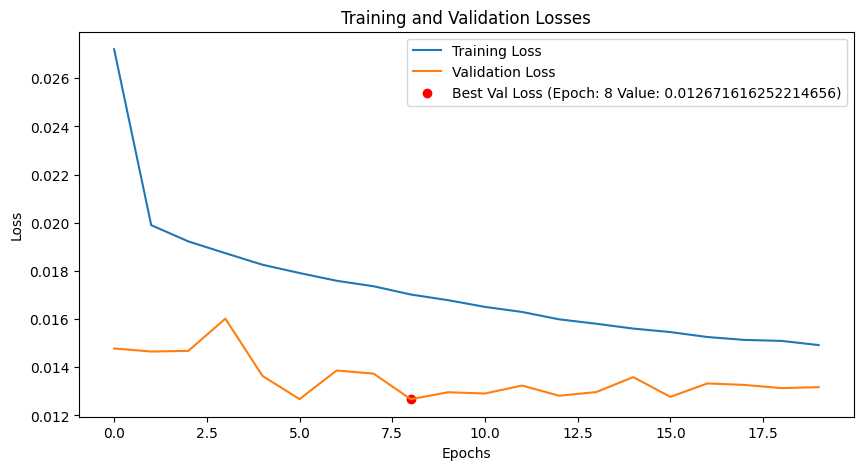

In [19]:
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(best_val_loss_epoch, best_val_loss, color='red', label=f'Best Val Loss (Epoch: {best_val_loss_epoch} Value: {best_val_loss})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
runtime.unassign()